In [1]:
from pathlib import Path

import torch
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image

In [2]:
root_data = 'data'
paths = {
    'train': Path(root_data, 'train'),
    'val': Path(root_data, 'validation'),
    'test': Path(root_data, 'test')
}

class_map = {
    'cleaned': 0,
    'dirty': 1,
}

mean = [0.5, 0.5, 0.5]
std = [0.25, 0.25, 0.25]

tfs = {
    'train': transforms.Compose([
        transforms.RandomPerspective(distortion_scale=0.2, p=0.1, interpolation=3, fill=255),
        transforms.RandomChoice([
            transforms.CenterCrop(180),
            transforms.CenterCrop(160),
            transforms.CenterCrop(140),
            transforms.Compose([
                transforms.CenterCrop(280),
                transforms.Grayscale(3),
            ]),
            transforms.Compose([
                transforms.CenterCrop(220),
                transforms.Grayscale(3),
            ])
        ]),
        transforms.Resize((224,224)),
        transforms.ColorJitter(hue=(0.1, 0.2)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ColorJitter(hue=(0.1, 0.2)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]),
}

target_tf = lambda x : torch.tensor(x, dtype=torch.float32)

datasets = {
    'train': torchvision.datasets.ImageFolder(root=paths['train'], transform=tfs['train'], target_transform=target_tf),
    'val': torchvision.datasets.ImageFolder(root=paths['val'], transform=tfs['train'], target_transform=target_tf),
    'test': torchvision.datasets.ImageFolder(root=paths['test'], transform=tfs['test'], target_transform=target_tf)
}

dataloaders = {
    'train': DataLoader(datasets['train'], batch_size=32, shuffle=True),
    'val': DataLoader(datasets['val'], batch_size=32, shuffle=False),
}

In [3]:

def to_pil(x):
    x = x.permute(1,2,0).detach().numpy() * std + mean
    x = to_pil_image(x)
    return x

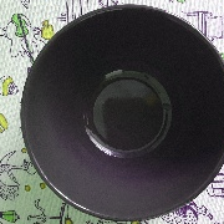

In [4]:
x = datasets['train'][0][0]
to_pil(x)

In [5]:
from torchvision.models import resnet18, ResNet18_Weights
from torch.nn import Linear

model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = Linear(model.fc.in_features, 1)

In [6]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=0.01)
loss_fn = torch.nn.MSELoss()

def accuracy(output, y):
    return (output == y).to(torch.uint8).sum() / len(y)

epochs = 5
for epoch in range(epochs):
    model.train()
    for X, y in dataloaders['train']:
        y = y.unsqueeze(dim=1)
        output = model(X)
        loss = loss_fn(output, y)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        acc = accuracy(output.round(), y)

    model.eval()
    for X, y in dataloaders['val']:
        y = y.unsqueeze(dim=1)
        with torch.no_grad():
            output = model(X)
            loss_val = loss_fn(output, y)
            acc_val = accuracy(output.round(), y)
    
    print(f'epoch | {epoch} | loss: {loss.item():.4f} | acc:{acc.item():0.4f} | val_loss:{loss_val.item():.4f} | val_acc: {acc_val.item():.4f}')


loss: 0.6432, acc:0.4688
loss: 0.5942, acc:0.4375
loss: 0.3339, acc:0.4062
loss: 0.5284, acc:0.4375
loss: 0.8215, acc:0.4167


In [7]:
# copy new images to train
# from pathlib import Path
# from utils.data.augment import copy
# for cls in ["cleaned", "dirty"]:
#     src_path = Path('data', 'new', cls)
#     target_path = Path('data', 'plates', 'train', cls)
#     copy(src_path, target_path)

In [8]:
# from ai.model import CModel
# cModel = CModel()
# loss_fn = torch.nn.BCEWithLogitsLoss()
# def loss(output, y):
#     y = torch.nn.functional.one_hot(y, num_classes=2).to(torch.float32)
#     return loss_fn(output, y)

# def accuracy(output, y):
#     return (output.argmax(dim=1) == y).to(torch.float32).sum() / len(y)

# metrics = {"loss": loss, "acc": accuracy}

# from ai.train import Learner

# optimizer = torch.optim.SGD(cModel.model.parameters(), lr=0.1, weight_decay=0.01)
# learner = Learner(cModel.model, optimizer, metrics, dataloaders['train'], dataloaders['val'])

# learner.run(epochs=1)